# Partially coded field of view with 2D masks

In [2]:
import numpy as np
import numpy.typing as npt
from scipy.signal import correlate
import matplotlib.pyplot as plt

We modify the function to generate URA mask so that it may return wrap-padded masks. This is to avoid confusion when padding with zeros for PCFOV. 

In [4]:
correlate([1,2,3], [1,2,3], mode="full")

array([ 3,  8, 14,  8,  3])

In [5]:
correlate([1,2,3], [1,2,3], mode="same")

array([ 8, 14,  8])

In [6]:
from masks.utils import is_prime


def _ura(r: int, s: int, m: int = 1, wrap_border=False) -> tuple[npt.NDArray, npt.NDArray]:
    """
    Generates a URA mask and its decoding array.

    From: `https://github.com/bpops/codedapertures` by https://github.com/bpops
    All credits reserved and thank you very much!
    TODO: bundle a license

    :param r: number of rows
    :param s: number of columns
    :param m: number of tiles
    :param wrap_borders: will wrap the fundamental tile around its border.
    :return: the mask array and its decoding array.
    """
    assert is_prime(r)
    assert is_prime(s)
    assert r - s == 2

    c_r_i = np.zeros(r) - 1
    c_s_j = np.zeros(s) - 1
    for x in range(1, r):
        c_r_i[x**2 % r] = 1
    for y in range(1, s):
        c_s_j[y**2 % s] = 1

    _a_ij = np.zeros([r, s])
    for i in range(r):
        for j in range(s):
            if i == 0:
                _a_ij[i, j] = 0
            elif j == 0:
                _a_ij[i, j] = 1
            elif c_r_i[i] * c_s_j[j] == 1:
                _a_ij[i, j] = 1

    a_ij = np.zeros([m * r, m * s])
    for i in range(m * r):
        for j in range(m * s):
            a_ij[i, j] = _a_ij[i % r, j % s]
    a_ij = np.roll(a_ij, int((r + 1) / 2), axis=0)
    a_ij = np.roll(a_ij, int((s + 1) / 2), axis=1)

    g_ij = a_ij.copy()
    g_ij[g_ij == 0] = -1
    return a_ij, g_ij


def _zero_pad(a: npt.NDArray) -> npt.NDArray:
    n, m = a.shape
    return np.pad(a, pad_width=((n // 2, n // 2), (m // 2, m // 2)), mode="constant")

def _wrap_border(a: npt.NDArray) -> npt.NDArray:
    return np.pad(
        a,
        pad_width=[(d // 2, d // 2) for d in a.shape],
        mode="wrap",
    )


class URA:
    def __init__(self, r: int, s: int, m: int = 1):
        if not (is_prime(r) and is_prime(s) and r - s == 2):
            raise ValueError("Incorrect initialization")
        self.r = r
        self.s = s
        self.m = m

    def _tile(self):
        return _ura(self.r, self.s, self.m)

    def _wrapped(self):
        a, g = map(lambda m: _wrap_border(m), self._tile())
        return a, g

    def _padded(self):
        a, g = map(lambda m: _zero_pad(_wrap_border(m)), self._tile())
        return a, g

    def _norm(self):
        return 1 / np.sum(self._tile())

    def encode(self, sky: npt.NDArray) -> npt.NDArray:
        n, m = sky.shape
        a, _ = self._padded()
        detector = correlate(a, sky)[n - 1 : -n + 1, m - 1 : -m + 1] * self._norm()
        # a, _ = self._wrapped()
        # detector = correlate(a, sky, mode="same") * self._norm()
        return detector

    def decode(self, detector: npt.NDArray, balanced: bool | npt.NDArray = False):
        n, m = detector.shape
        _, g = self._padded()
        cc = correlate(g, detector)[n - 1 : -n + 1, m - 1 : -m + 1]
        if balanced is False:
            return cc
        elif balanced is True:
            bulk = np.ones(detector.shape)
        else:
            bulk = balanced
        return cc - correlate(g, bulk)[n - 1 : -n + 1, m - 1 : -m + 1] * np.sum(detector) / np.sum(bulk)

    def get_mask(self, zero_padded=False) -> npt.NDArray:
        f = self._padded if zero_padded else self._wrapped
        a, _ = f()
        return a

    def get_encoder(self, zero_padded=False) -> npt.NDArray:
        f = self._padded if zero_padded else self._wrapped
        _, g = f()
        return a

    def get_sky_canvas(self) -> npt.NDArray:
        return np.zeros((self.r + 2 * (self.r - 1), self.s + 2 * (self.s - 1)))

In [24]:
ura = URA(61, 59)
mask = ura.get_mask()

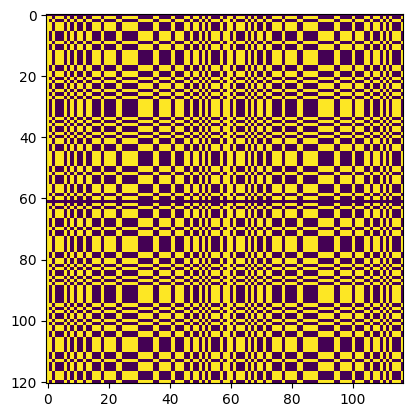

In [25]:
plt.imshow(mask); plt.show()

In [26]:
sky = ura.get_sky_canvas()
for source in [(ura.r // 2 + ura.r, ura.s // 2 + ura.s, 1000)]:
    x, y, counts = source
    sky[x, y] = counts

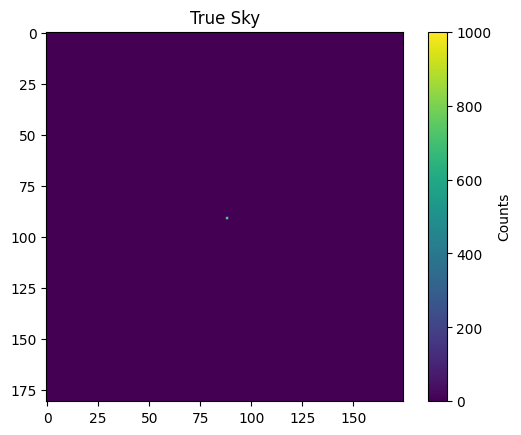

In [27]:
fig, ax = plt.subplots(1, 1)
c0 = ax.imshow(sky)
fig.colorbar(c0, ax=ax, label="Counts")
ax.set_title("True Sky")
plt.show()

In [28]:
detector = ura.encode(sky)

In [29]:
detector.shape

(61, 59)

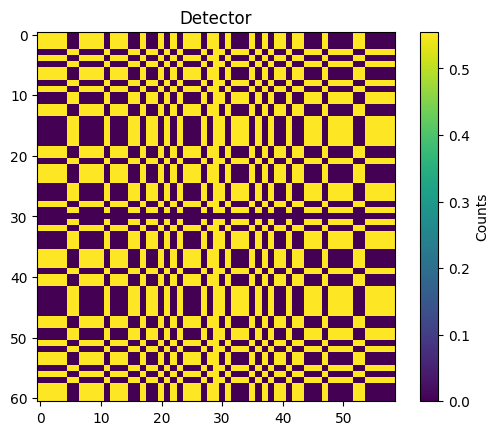

In [30]:
fig, ax = plt.subplots(1, 1)
c0 = ax.imshow(detector)
fig.colorbar(c0, ax=ax, label="Counts")
ax.set_title("Detector")
plt.show()

In [31]:
np.sum(detector)

np.float64(999.444752915047)

In [32]:
reconstructed = ura.decode(detector, balanced=False)
balanced_ = ura.decode(detector, balanced=True)

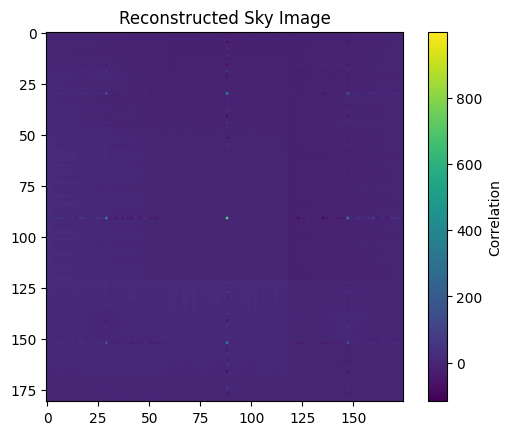

In [33]:
fig, ax = plt.subplots(1, 1)
c0 = ax.imshow(reconstructed)
fig.colorbar(c0, ax=ax, label="Correlation")
ax.set_title("Reconstructed Sky Image")
plt.show()

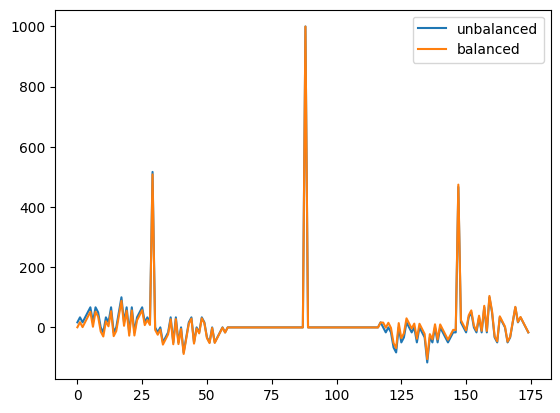

In [34]:
plt.plot(reconstructed[len(reconstructed) // 2 + 1], label="unbalanced")
plt.plot(balanced_[len(balanced_) // 2 + 1], label= "balanced")
plt.legend()

In [19]:
_, g = ura._padded()
bulk = np.ones(detector.shape)
gplus = g.copy()
gplus[g <= 0] = 0
gminus = g.copy()
gminus[g >= 0] = 0
gminus *= -1

In [38]:
from tqdm import tqdm

balanced = ura.get_sky_canvas()
i_, j_ = sky.shape
k_, l_ = detector.shape
for i in tqdm(range(i_)):
    for j in range(j_):
        num = 0
        den = 0
        for k in range(k_):
            for l in range(l_):
                num += gplus[i + k, j + l] * bulk[k, l] * detector[k, l]
                den += gplus[i + k, j + l] * bulk[k, l]
        gplus_term = num / den

        num = 0
        den = 0
        for k in range(k_):
            for l in range(l_):
                num += gminus[i + k, j + l] * bulk[k, l] * detector[k, l]
                den += gminus[i + k, j + l] * bulk[k, l]
        gminus_term = num / den

        balanced[i, j] = gplus_term - gminus_term
        

  0%|                                                   | 0/181 [00:00<?, ?it/s]/var/folders/lm/lygtn2dd4kzdksfx5w6c2xyr0000gn/T/ipykernel_60016/860919725.py:14: RuntimeWarning: invalid value encountered in scalar divide
  gplus_term = num / den
 67%|███████████████████████████▋             | 122/181 [01:29<00:43,  1.36it/s]/var/folders/lm/lygtn2dd4kzdksfx5w6c2xyr0000gn/T/ipykernel_60016/860919725.py:22: RuntimeWarning: invalid value encountered in scalar divide
  gminus_term = num / den
100%|█████████████████████████████████████████| 181/181 [02:13<00:00,  1.36it/s]


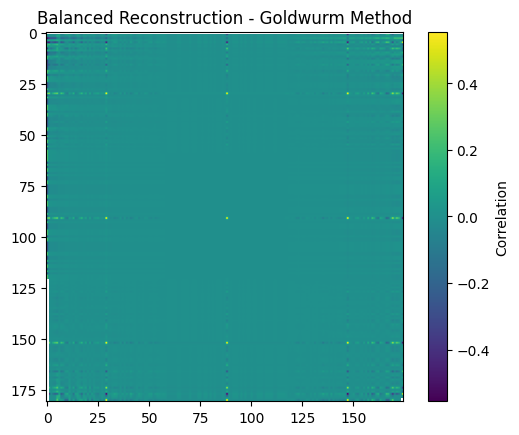

In [39]:
fig, ax = plt.subplots(1, 1)
c0 = ax.imshow(balanced)
fig.colorbar(c0, ax=ax, label="Correlation")
ax.set_title("Balanced Reconstruction - Goldwurm Method")
plt.show()

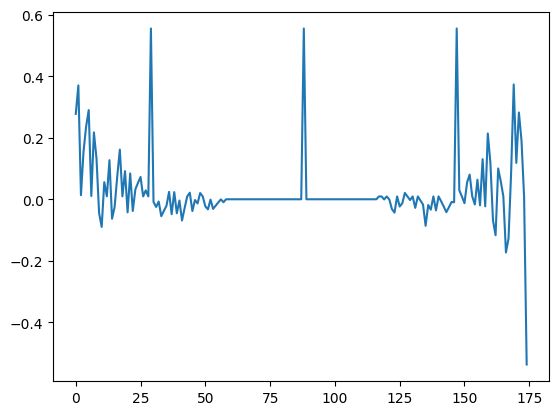

In [46]:
plt.plot(balanced[len(balanced) // 2 + 1])

In [40]:
balanced_ = ura.decode(detector, balanced = True)

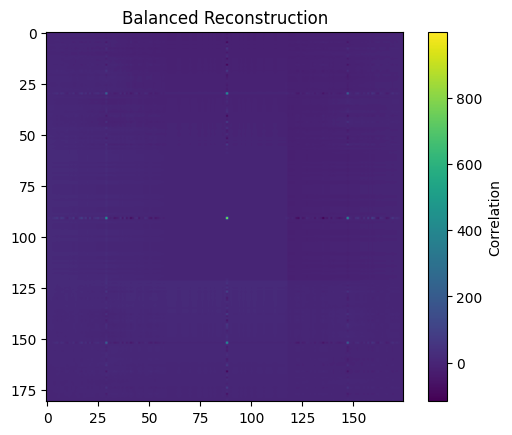

In [41]:
fig, ax = plt.subplots(1, 1)
c0 = ax.imshow(reconstructed)
fig.colorbar(c0, ax=ax, label="Correlation")
ax.set_title("Balanced Reconstruction")
plt.show()

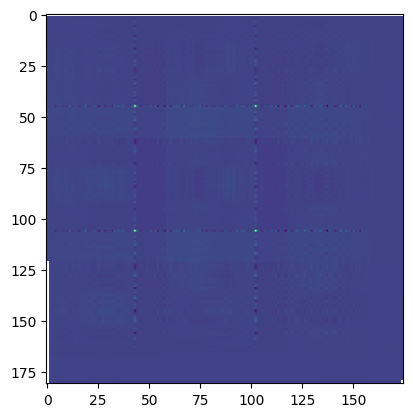

In [20]:
plt.imshow(balanced_ - balanced)